### This project seeks to predict future MLB Hall of Fame members. So far, it includes only hitters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
batting = pd.read_csv('./baseballdatabank-2022.2/core/Batting.csv')
people = pd.read_csv('./baseballdatabank-2022.2/core/People.csv')
allstar = pd.read_csv('./baseballdatabank-2022.2/core/AllstarFull.csv')
HOF = pd.read_csv('./baseballdatabank-2022.2/contrib/HallOfFame.csv')

## Main DataFrame

Beginning with the "Batting" file, we first want to find the career achievements of each player, so we must group by playerID to do this. We will also add a list of the columns we wish to keep from the file.

In [3]:
player_total_stats = batting.groupby(['playerID'])[['G', 'AB', 'R', 'H','2B', '3B', 'HR', 'RBI', 
                                                   'SB', 'BB', 'SO', 'IBB', 'HBP', 'SF']].sum()

This will be 'main' dataframe, so to say, throughout the cleaning process, as all other dataframes will be left joined to player_total_stats through the playerID column.

## People DataFrame

The columns debut and finalGame from the 'people' file are considered objects in pandas despite representing datatime, so we can use the pandas implimentation to switch the data type and allow us to easily munipulate the data. Also, we will add a retirement column to the dataframe. Currently, the Hall of Fame requires that a player must be 5 years removed from league to be eligible for consideration, so this column will be vital to determining qualification. 

In [4]:
# converting to datetime and adjusting for dates > 2022
# i.e. someone was born in 1926 (5-6-26) but the 'to_datetime' function interprets it as 2026
people['debut'] = pd.to_datetime(people['debut'])
people.loc[people['debut'].dt.year >= 2022, 'debut'] -= pd.DateOffset(years=100)
people['finalGame'] = pd.to_datetime(people['finalGame'])
people.loc[people['finalGame'].dt.year >= 2022, 'finalGame'] -= pd.DateOffset(years=100)

Next, we can create a retirement column to determine eligibility to the HoF. Using pd.cut allows us to "bin" the data into ranges, which is what we need. The first bin is for players too recent to playing to be in the HoF, whereas label 1 are players who are eligible.

In [5]:
people['retirement'] = pd.to_datetime('today') - people['finalGame']
people['retirement'] = people['retirement'] / np.timedelta64(1, 'Y')

people['eligible'] = pd.cut(people['retirement'], bins = [0, 5, 1000], labels = ['too young', 'eligible'])

In [6]:
people['CareerLength'] = people['finalGame'] - people['debut']
people['CareerLength'] = people['CareerLength'] / np.timedelta64(1, 'Y')

In [7]:
# same problem as above
# i.e. sometimes someone would start in '16 and end in '20 and it would be interpreted as starting in 2016 and ending in 1920
# adding 100 to players who have a negative career length solves this problem
people.loc[people['CareerLength'] < 0, 'CareerLength'] += 100
people.loc[people['CareerLength'] > 100, 'CareerLength'] -= 100

The columns 'bats' and 'eligible' are still not numerical, so we can use '.get_dummies' to do this for us. It is a pandas implimentation of one hot encoding, and allows us to quickly binary encode our categorical data.

In [8]:
# One hot encoding for some categorical variables
people = pd.get_dummies(people, columns = ['bats', 'eligible'], prefix= ['bats', 'is'], drop_first=True, dtype='float')

In [9]:
people['Name'] = people['nameFirst'] + ' ' + people['nameLast']

The following columns are the only ones which we wish to bring to the 'main' dataframe. However, there are players in this dataframe that do not have column values : weight, height, bats, and throws. For height and weight, where they are relatively normal in distribution, we will fit the missing values with the mean, and for bats and throws, we will fill with 0 (bats right and throws right) since this is the dominant orientation.

In [10]:
people = people[['playerID', 'birthCountry', 'weight', 'height', 'bats_L', 'bats_R', 'CareerLength', 'is_eligible', 'Name']]
player_total_stats = player_total_stats.merge(people, left_on = 'playerID', right_on = 'playerID')

In [11]:
player_total_stats['height'] = player_total_stats['height'].fillna(player_total_stats['height'].mean())
player_total_stats['weight'] = player_total_stats['weight'].fillna(player_total_stats['weight'].mean())
player_total_stats['birthCountry'] = player_total_stats['birthCountry'].fillna('USA')

## Allstar DataFrame

Now, onto the allstar dataframe, we are really only interested on the number of allstar game selection a player has, so we can use count to find this number. The GP column (games played) can be added to find such a number, which we rename in the next line to be "ASGames". Once this is done we can merge with player_total_stats

In [12]:
allstar = allstar.groupby(['playerID'])[['GP']].count()
allstar.rename(columns = {'GP':'ASGames'}, inplace = True)

player_total_stats = player_total_stats.merge(allstar, how = 'left', left_on = 'playerID', right_on = 'playerID')

Because we are using left join, there are many players who have null all star game apperances. This simply means that they did not have any apperances, and we can fill each null with 0. 

In [13]:
player_total_stats['ASGames'] = player_total_stats['ASGames'].fillna(0)

## HOF DataFrame

We begin by 'bool'erizing our data, so to say, and extracting the two columns that pertain to the project. After we merge to the main dataframe, we can binarize the data and also fill in null values.

In [14]:
HOF = HOF[HOF['votedBy'] == 'BBWAA']
HOF = HOF[HOF['inducted'] == 'Y']
HOF = HOF[['playerID', 'inducted']]

In [15]:
player_total_stats = player_total_stats.merge(HOF, how = 'left', left_on = 'playerID', right_on = 'playerID')

In [16]:
player_total_stats['inducted'] = player_total_stats['inducted'].fillna(0)
player_total_stats['inducted'] = player_total_stats['inducted'].where(player_total_stats['inducted'] == 0, 1)
player_total_stats['inducted'] = player_total_stats['inducted'].astype(int)

## Feature Selection

Bill James, one of the founders of modern baseball statistics, came up with several metrics for a players performance in his book, 'The Politics of Glory'. The one most relavent to our dataframe is called the "Hall of Fame Career Standards Test". These metrics can be found in his book on p. 174-176. All values are for career marks.

Batting Statistics
- 1 One point for each 150 hits above 1500, limit 10.
- 2 One point for each .005 of batting average above .275, limit 9
- 3 One point for batting over .300
- 4 One point for each 100 runs over 900, limit 8.
- 5 One point for scoring more than .500 runs per game.
- 6 One point for scoring more than .644 runs per game.
- 7 One point for each 100 rbi's over 800, limit 8.
- 8 One point for driving in more than .500 runs per game.
- 9 One point for driving in more than .600 runs per game.
- 10 One point for each .025 of slugging percentage above .300, limit 10
- 11 One point for each .010 of on-base percentage above .300, limit 10
- 12 One point for each 200 home runs.
- 13 One point if home runs are more than 10% of hits.
- 14 One point if home runs are more than 20% of hits.
- 15 One point for each 200 extra base hits over 300, limit 5.
- 16 One point for each 200 walks over 300, limit 5.
- 17 One point for each 100 stolen bases, limit 5.

In [17]:
def CST(data):
    
    data[1] = np.floor((data['H'] - 1500) / 150).clip(0, 10)
    data[2] = np.floor(((data['H'] / data['AB']) - 0.275)/0.005).clip(0,9)
    data[3] = np.ceil((data['H'] / data['AB']) - 0.3).clip(0,1)
    data[4] = np.floor((data['R'] - 900) / 100).clip(0, 8)
    data[5] = np.ceil(((data['R'] / data['G']) - 0.500)).clip(0,1)
    data[6] = np.ceil(((data['R'] / data['G']) - 0.644)).clip(0,1)
    data[7] = np.floor((data['RBI'] - 800) / 100).clip(0, 8)
    data[8] = np.ceil(((data['RBI'] / data['G']) - 0.500)).clip(0,1)
    data[9] = np.ceil(((data['RBI'] / data['G']) - 0.600)).clip(0,1)
    data[10] = np.floor((((data['H'] + 2*data['2B'] + 3*data['3B'] + 4*data['HR'])/data['AB']) - 0.3)/0.025).clip(0,10)
    data[11] = np.floor((((data['H'] + data['BB'] + data['HBP'])/(data['AB'] + data['BB'] + data['HBP'] + data['SF'])) - 0.3)/0.01).clip(0,10)
    data[12] = np.floor(data['HR'] / 200)
    data[13] = np.ceil(((data['HR'] / data['H']) - 0.1)).clip(0,1)
    data[14] = np.ceil(((data['HR'] / data['H']) - 0.2)).clip(0,1)
    data[15] = np.floor(((data['2B'] + data['3B'] + data['HR']) - 300) / 200).clip(0, 5)
    data[16] = np.floor((data['BB'] - 300) / 200).clip(0, 5)
    data[17] = np.floor(data['SB'] / 100).clip(0, 5)
    
    data['CST'] = data[1]
    for i in range(16):
        data['CST'] += data[i + 2]
    data['CST'] = data['CST'].fillna(0)
    
    data = data.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17] , axis = 1)
    
    return data

In [18]:
player_total_stats = CST(player_total_stats)

An 'unoffical' metric of CST is that the player must have at least 1,000 at bats (AB) to have a reasonable chance of having a Hall of Fame worthy score. 

In [19]:
player_total_stats = player_total_stats[player_total_stats['AB'] >= 1000].sort_values('AB', ascending=False)

We have two columns (playerID and birthCountry) that are not numeric, so it would be helpful to have a dataframe that consists only of numerical columns.

In [20]:
pts_num = player_total_stats.drop(['playerID', 'birthCountry', 'Name'], axis = 1)

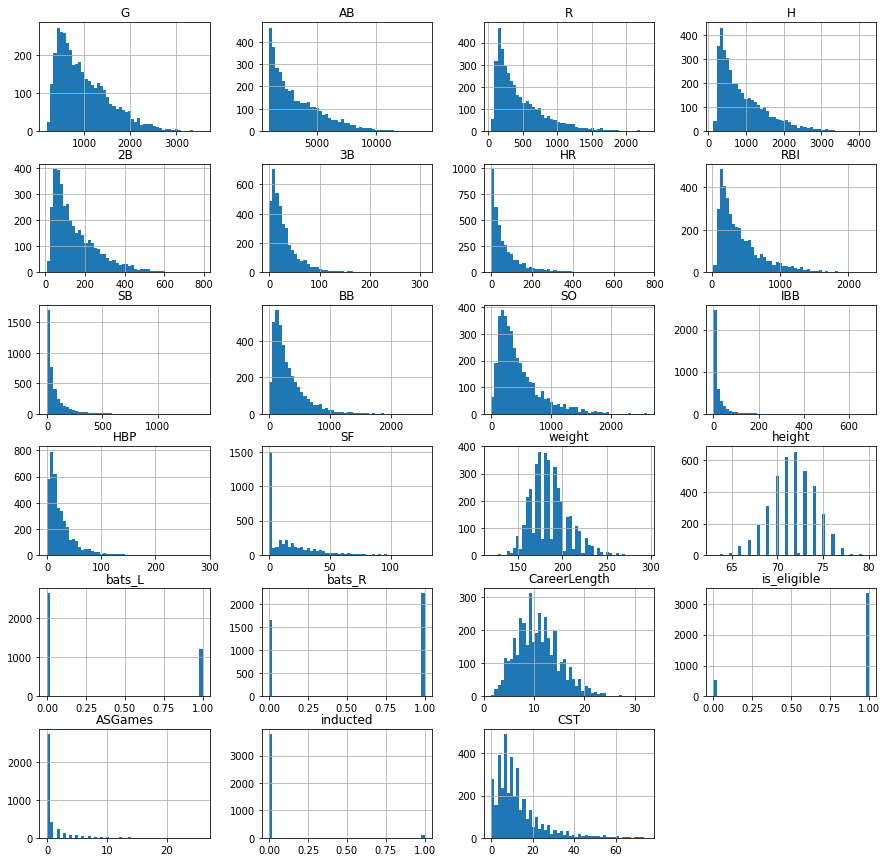

In [21]:
pts_num.hist(bins=50, figsize=(15, 15), layout=(6, 4));

## Dealing with right-skewed data

as you can see above, most all of our numerical data has at least somewhat of a right skew, which is fine for simple data analysis, but is not ideal for machine learning models. Thus, we need to find a good way of 'normalizing' our data without losing the relational aspect of the data.

Below are the columns that need to be rescaled.

In [22]:
col_tochange = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 
                'SO', 'IBB', 'HBP', 'SF','ASGames', 'CareerLength', 'CST']

The issue with choosing the logorithmic function to scale our data is that at zero, the value of log(X) is negative infinity, which of course is not ideal. Thus, we need a slight shift to make sure that this does not occur. The addition of 0.5 is arbitrary, I have not tested all changes between 0 and 1, and perhaps there is a better constant to add.

In [23]:
pts_temp = pts_num
for x in col_tochange:
    pts_temp[x] = np.log(pts_num[x] + 0.5)

Now it would be useful for the model that all of our data ranges from 0 to 1. The following code does that nicely

In [24]:
pts_num = pts_temp

for x in pts_num.columns:
    pts_num[x] = pts_temp[x] - pts_temp[x].min()
    pts_num[x] = pts_num[x] / pts_num[x].max()

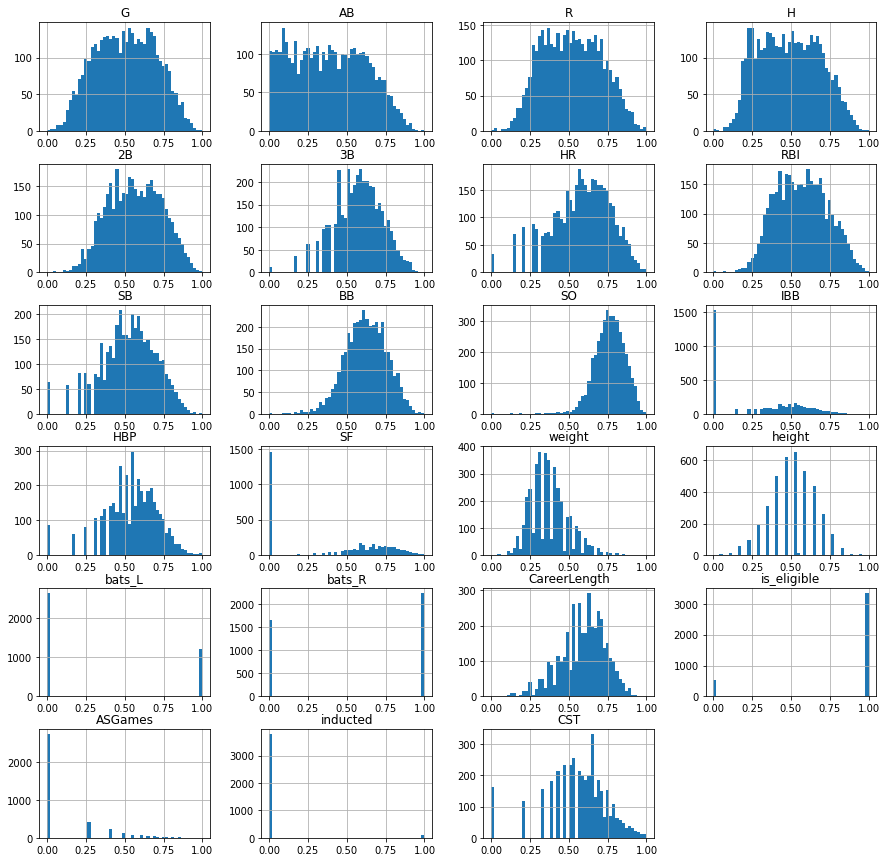

In [25]:
pts_num.hist(bins=50, figsize=(15, 15), layout=(6, 4));

## Final DataFrames

In [26]:
player_total_stats.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,...,weight,height,bats_L,bats_R,CareerLength,is_eligible,Name,ASGames,inducted,CST
15679,rosepe01,3562,14053,2165,4256,746,135,160,1314.0,198.0,...,192.0,71.0,0.0,0.0,23.359823,1.0,Pete Rose,17.0,0,53.0
1,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,240.0,...,180.0,72.0,0.0,1.0,22.475479,1.0,Hank Aaron,24.0,1,70.0
19965,yastrca01,3308,11988,1816,3419,646,59,452,1844.0,168.0,...,175.0,71.0,1.0,0.0,22.475479,1.0,Carl Yastrzemski,18.0,1,60.0
15282,ripkeca01,3001,11551,1647,3184,603,44,431,1695.0,36.0,...,200.0,76.0,0.0,1.0,20.156471,1.0,Cal Ripken,19.0,1,50.0
3366,cobbty01,3035,11436,2247,4189,724,295,117,1944.0,896.0,...,175.0,73.0,1.0,0.0,23.031958,1.0,Ty Cobb,0.0,1,73.0


In [27]:
pts_num.head()

,G,AB,R,H,2B,3B,HR,RBI,SB,BB,...,SF,weight,height,bats_L,bats_R,CareerLength,is_eligible,ASGames,inducted,CST
15679,1.000000,1.000000,0.984885,1.000000,0.986170,0.871504,0.787399,0.878155,0.753454,0.922660,...,0.913468,0.411429,0.470588,0.0,0.0,0.885919,1.0,0.895488,0.0,0.931347
1,0.972965,0.951543,0.985961,0.965133,0.944900,0.821891,0.998742,1.000000,0.777620,0.905225,...,0.989906,0.342857,0.529412,0.0,1.0,0.872518,1.0,0.980235,1.0,0.986343
19965,0.974027,0.939856,0.939323,0.936894,0.952908,0.743473,0.928809,0.952076,0.732823,0.948500,...,0.964459,0.314286,0.470588,1.0,0.0,0.872518,1.0,0.909484,1.0,0.955855
15282,0.939833,0.925803,0.914006,0.916374,0.936989,0.698283,0.922325,0.933696,0.540224,0.871097,...,0.998592,0.457143,0.764706,0.0,1.0,0.834766,1.0,0.922744,1.0,0.919845
3366,0.943788,0.922016,0.994521,0.995427,0.979252,0.992799,0.744853,0.963598,0.943294,0.887015,...,0.000000,0.314286,0.588235,1.0,0.0,0.881010,1.0,0.000000,1.0,0.994649


### Using SMOTE to deal with unbalanced data

In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

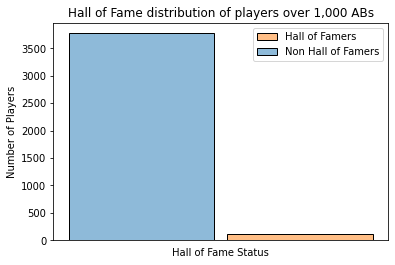

In [29]:
sns.histplot(data = pts_num, x = 'inducted', hue='inducted', shrink= 11);
plt.ylabel('Number of Players');
plt.xlabel('Hall of Fame Status');
plt.title('Hall of Fame distribution of players over 1,000 ABs');
plt.xticks(np.arange(0,0,1));
plt.legend(labels = ['Hall of Famers', 'Non Hall of Famers']);

As is evident from the above chart, we have many more cases of players not in the Hall of Fame compared to players who have been inducted. This is an issue since it will lead the models we create to simply just guess each player to not be inducted, which is pointless for the sake of this project. Thus, we need to balance the data. 

SMOTE, or Synthetic Minority Oversampling Technique, is used as a type of oversampling to help balance our data. It uses a 'nearest neighbors' techneque to come up with many psuedo-positive cases, which in turn gives us balance.

In [30]:
X = pts_num.query('is_eligible == 1')
y = X.inducted
X = X.drop(['is_eligible', 'inducted'], axis=1)

Below we are splitting the data into X (the given data), and y (the output we want to predict). Using training and testing splits is a common feature of ML models, which decreases the chances of the model overfitting to the given data.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [32]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

Using SMOTE, our data is now completely balanced.

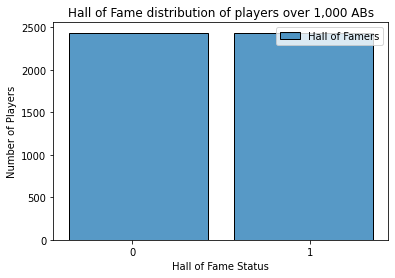

In [33]:
sns.histplot(data = y_smote, shrink= 11);
plt.ylabel('Number of Players');
plt.xlabel('Hall of Fame Status');
plt.title('Hall of Fame distribution of players over 1,000 ABs');
plt.xticks(np.arange(0,2,1));
plt.legend(labels = ['Hall of Famers', 'Non Hall of Famers']);

## Model selection and tuning

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [35]:
model = LogisticRegression(solver='saga')
model.fit(X_smote, y_smote)

LogisticRegression(solver='saga')

In [36]:
y_pred = model.predict(X_test)

In [37]:
matrix = confusion_matrix(y_test, y_pred)
print('True neg. =', matrix[0][0])
print('False pos. =', matrix[0][1])
print('True pos. =', matrix[1][1])
print('False neg. =', matrix[1][0])
print('Looking for a descending order here')

True neg. = 741
False pos. = 71
True pos. = 22
False neg. = 4
Looking for a descending order here


In [38]:
from sklearn.metrics import roc_auc_score
print(str(np.round(roc_auc_score(y_test, y_pred), 3) * 100) + '%')

87.9%


In [39]:
X_curr_players = player_total_stats.query('is_eligible == 0')

In [40]:
player_look_up = pd.read_csv('./baseballdatabank-2022.2/core/People.csv')
player_look_up.drop(['birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameGiven', 'weight', 
       'height', 'bats', 'throws', 'debut', 'finalGame', 'retroID', 'bbrefID'], axis=1, inplace=True)
player_look_up['Name'] = player_look_up['nameFirst'] + ' ' + player_look_up['nameLast']
player_look_up.drop(['nameFirst', 'nameLast'], axis=1, inplace=True)
player_look_up = X_curr_players.merge(player_look_up, how = 'left', left_on = 'playerID', right_on = 'playerID')
player_look_up = player_look_up.drop(['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB',
       'SO', 'IBB', 'HBP', 'SF', 'birthCountry', 'weight', 'height', 'bats_L',
       'bats_R', 'CareerLength', 'is_eligible', 'ASGames', 'inducted',
       'CST'], axis=1)

player_look_up['Name'] = player_look_up['Name_x']
player_look_up = player_look_up.drop(['Name_y', 'Name_x'], axis =1)

In [41]:
import pickle

# save
#with open('improved_model.pkl','wb') as f:
#    pickle.dump(model,f)
#with open('X_curr_players.pkl','wb') as f:
#    pickle.dump(X_curr_players,f)
#with open('history.pkl','wb') as f:
#    pickle.dump(player_total_stats,f)
#with open('player_look_up_v2.pkl','wb') as f:
#    pickle.dump(player_look_up,f)
with open('pts_num.pkl', 'wb') as f:
    pickle.dump(pts_num, f)